<h1>I. Problem Statement</h1>

Perusahaan e-commerce menghadapi tantangan dalam mengelola operasionalnya, khususnya dalam hal manajemen stok dan pengiriman. Berdasarkan data yang tersedia, terlihat beberapa masalah yang perlu ditangani untuk meningkatkan efisiensi operasional.<br><br>
**Latar Belakang Masalah**<br><br>
Perusahaan memiliki beragam kategori produk dengan karakteristik yang berbeda-beda. Setiap kategori menunjukkan pola manajemen stok yang unik, mulai dari umur stok, tingkat turnover, hingga kebutuhan safety stock. Selain itu, sistem pengiriman juga menunjukkan variasi performa yang signifikan antar wilayah dan kategori produk.

**Identifikasi Masalah Utama**<br><br>

Kinerja Pengiriman

* Durasi pengiriman bervariasi antar wilayah
* Tingkat pembatalan dan pengembalian produk perlu dianalisis
* Efisiensi distribusi belum optimal

Manajemen Stok

* Terdapat variasi umur stok yang signifikan antar kategori produk
* Beberapa kategori menunjukkan turnover stok yang rendah
* Kebutuhan safety stock belum dioptimalkan
* Ada indikasi overstocking di beberapa kategori


**Penjabaran Masalah**
* Apa penyebab variasi durasi pengiriman antar wilayah?
* Bagaimana pola pembatalan dan pengembalian produk?
* Bagaimana pola distribusi umur stok antar kategori produk?
* Faktor apa saja yang mempengaruhi tingkat turnover stok?
* Bagaimana mengoptimalkan level safety stock untuk setiap kategori?


<h1>II. Data Load</h1>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from geopy.distance import geodesic


In [3]:
pd.options.mode.copy_on_write = True

In [4]:
inventory_item = pd.read_csv('Data/inventory_items.csv')
order = pd.read_csv('Data/order.csv')
order_items = pd.read_csv('Data/order_items.csv')
product = pd.read_csv('Data/products.csv')
user = pd.read_csv('Data/user.csv')
dc_loc = pd.read_csv('Data/dc.csv')

C:\Users\Ideapad Pro 5i\AppData\Local\Temp\ipykernel_17096\3160174799.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  user = pd.read_csv('Data/user.csv')


In [4]:
# Daftar kolom tanggal yang perlu dikonversi
date_columns_inventory = ['created_at', 'sold_at']
date_columns_order_items = ['created_at', 'shipped_at', 'delivered_at', 'returned_at']
date_columns_order = ['created_at', 'shipped_at', 'delivered_at', 'returned_at']

# Fungsi untuk mengkonversi kolom tanggal
def convert_to_datetime(df, date_columns):
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

# Konversi semua kolom tanggal ke datetime
inventory_item = convert_to_datetime(inventory_item, date_columns_inventory)
order_items = convert_to_datetime(order_items, date_columns_order_items)
order = convert_to_datetime(order, date_columns_order)

<h1>III. Data Analysis</h1>

<h2>A. Shipping Performence</h2>

In [5]:
total_orders = len(order)
shipped_orders = order['shipped_at'].notnull().sum()
shipping_rate = shipped_orders / total_orders * 100
print(f'Total order yang dibuat : {total_orders}')
print(f'Order yang berhasil dikirim sebanyak: {shipped_orders} (Shipping rate {shipping_rate:.2f}%)')

Total order yang dibuat : 11272
Order yang berhasil dikirim sebanyak: 7403 (Shipping rate 65.68%)


In [6]:
order.status.value_counts()

status
Shipped       3439
Complete      2869
Processing    2227
Cancelled     1642
Returned      1095
Name: count, dtype: int64

<h3>1. Kecepatan barang mulai dikirim</h3>

In [7]:
order['shipping_duration'] = (order['shipped_at'] - order['created_at']).dt.days
order['delivery_duration'] = (order['delivered_at'] - order['shipped_at']).dt.days

avg_shipping_time = order['shipping_duration'].mean()
avg_delivery_time = order['delivery_duration'].mean()
print(f'Rata-rata waktu pengiriman barang: {avg_shipping_time:.2f} hari')
print(f'Rata-rata barang terkirim ke konsumen: {avg_delivery_time:.2f} hari')

Rata-rata waktu pengiriman barang: 0.99 hari
Rata-rata barang terkirim ke konsumen: 1.97 hari


In [8]:
i = 1
while True:
    late_shipping = order[order['shipping_duration'] > i].shape[0]
    late_shipping_rate = late_shipping / shipped_orders * 100
    print(f'Persentase keterlambatan pengiriman lebih dari {i} hari : {late_shipping_rate:.2f} %')
    i+= 1
    if late_shipping_rate == 0:
        break

Persentase keterlambatan pengiriman lebih dari 1 hari : 33.05 %
Persentase keterlambatan pengiriman lebih dari 2 hari : 0.00 %


Dari hasil analisa rata-rata barang mulai dikirim ke konsumen yaitu 0.99 hari dimana tergolong baik dan cepat. Namun masih ada keterlambatan pengiriman lebih dari satu hari sebesar 33.05%. Perlu dianalisi lebih lanjut dengan data yang ada untuk mengetahui permasalahan keterlambatan pengiriman.

<h4>1.1 Pengaruh Waktu Orderan Dibuat Terhadap Keterlambatan Pengiriman Barang</h4>

a. Analisis distribusi late shipping berdasarkan jam

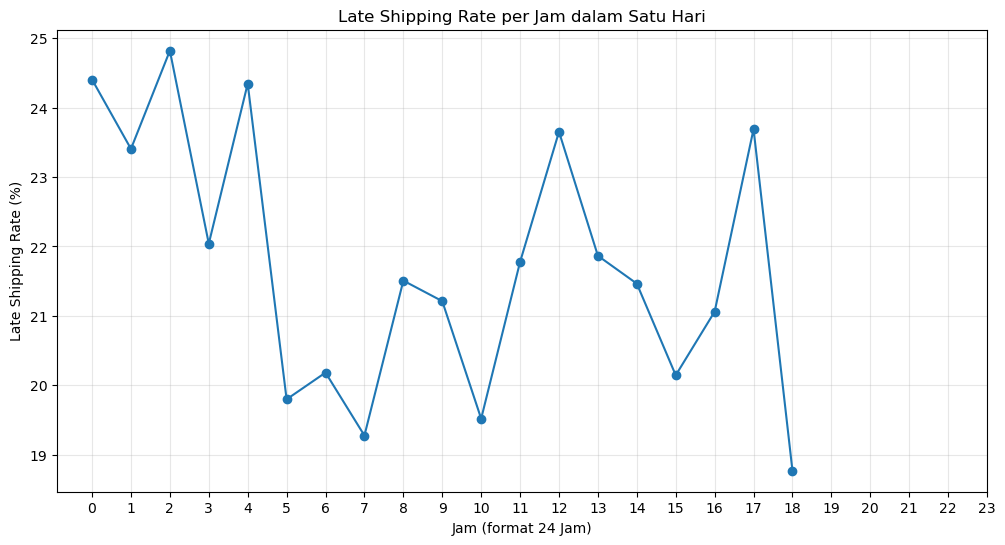

In [9]:
# Buat kolom untuk menandai late shipping
order['is_late'] = order['shipping_duration'] > 1

# Analisis berdasarkan jam
hourly_analysis = order.groupby(order['created_at'].dt.hour)['is_late'].agg(['count', 'sum', 'mean'])
hourly_analysis = hourly_analysis.rename(columns={'count': 'total_orders', 
                                                'sum': 'late_orders', 
                                                'mean': 'late_rate'})

# Visualisasi late rate berdasarkan jam
plt.figure(figsize=(12, 6))
plt.plot(hourly_analysis.index, hourly_analysis['late_rate'] * 100, marker='o')
plt.title('Late Shipping Rate per Jam dalam Satu Hari')
plt.xlabel('Jam (format 24 Jam)')
plt.ylabel('Late Shipping Rate (%)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.show()



In [10]:
print("\nAnalisis Statistik Late Shipping berdasarkan waktu:")
print("\nJam dengan late rate tertinggi:")
print(hourly_analysis.nlargest(3, 'late_rate')[['total_orders', 'late_orders', 'late_rate']])
print("\nJam dengan late rate terendah:")
print(hourly_analysis.nsmallest(3, 'late_rate')[['total_orders', 'late_orders', 'late_rate']])


Analisis Statistik Late Shipping berdasarkan waktu:

Jam dengan late rate tertinggi:
            total_orders  late_orders  late_rate
created_at                                      
2                    548          136   0.248175
0                    586          143   0.244027
4                    571          139   0.243433

Jam dengan late rate terendah:
            total_orders  late_orders  late_rate
created_at                                      
18                   602          113   0.187708
7                    581          112   0.192771
10                   625          122   0.195200


b. Analisis berdasarkan hari dalam seminggu

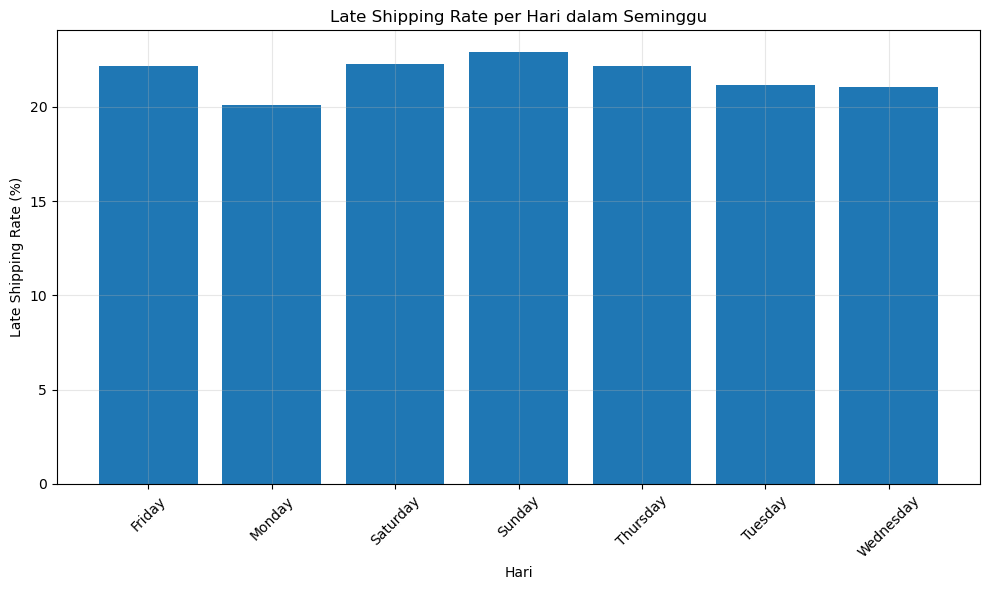

In [11]:
daily_analysis = order.groupby(order['created_at'].dt.day_name())['is_late'].agg(['count', 'sum', 'mean'])
daily_analysis = daily_analysis.rename(columns={'count': 'total_orders', 
                                              'sum': 'late_orders', 
                                              'mean': 'late_rate'})
# Visualisasi late rate berdasarkan hari
plt.figure(figsize=(10, 6))
plt.bar(daily_analysis.index, daily_analysis['late_rate'] * 100)
plt.title('Late Shipping Rate per Hari dalam Seminggu')
plt.xlabel('Hari')
plt.ylabel('Late Shipping Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
print("\nAnalisis Statistik Late Shipping berdasarkan hari:")
print(daily_analysis.sort_values('late_rate', ascending=False))


Analisis Statistik Late Shipping berdasarkan hari:
            total_orders  late_orders  late_rate
created_at                                      
Sunday              1645          377   0.229179
Saturday            1606          358   0.222914
Thursday            1605          356   0.221807
Friday              1592          353   0.221734
Tuesday             1606          340   0.211706
Wednesday           1627          343   0.210817
Monday              1591          320   0.201131


c. Uji statistik (Chi-square test)

In [13]:
#Membuat dataframe test
test_hour = pd.crosstab(order['created_at'].dt.hour, order['is_late'])
chi2, p_value, dof, expected = chi2_contingency(test_hour)

print("\nUji Statistik:")
print(f"Chi-square test p-value untuk pengaruh jam: {p_value:.4f}")
if p_value < 0.05:
    print("Ada hubungan signifikan antara jam pemesanan dengan keterlambatan pengiriman")
else:
    print("Tidak ada hubungan signifikan antara jam pemesanan dengan keterlambatan pengiriman")


Uji Statistik:
Chi-square test p-value untuk pengaruh jam: 0.2417
Tidak ada hubungan signifikan antara jam pemesanan dengan keterlambatan pengiriman


<p>Late shipping rate pada setiap jam dalam satu hari menunjukkan tidak ada jam-jam tertentu yang berpengaruh kuat dalam keterlambatan pengiriman barang. Jumlah keterlambatan setiap jamnya juga cenderung identik. Diperkuat dengan uji statistik juga menunjukkan tidak ada hubungan signifikan antara jam pemesanan dengan keterlambatan pengiriman. Hal ini menandakan tidak ada keterlambatan karena order dibuat karena diluar jam operasional.<br><br>
Untuk analisa hari terhadap late shipping rate juga menunjukkan tidak ada hari tertentu yang mengakibatkan keterlambatan lebih besar.<br>
Jadi waktu bukan menjadi faktor yang kuat mempengaruhi pengiriman barang.</p>

<h4>1.2 Pengaruh Quantity Barang dalam Order</h4>

a. Analisa Statistik

Statistik jumlah item berdasarkan status pengiriman:
          count      mean       std  min  25%  50%  75%  max
is_late                                                     
False    8825.0  1.456657  0.818369  1.0  1.0  1.0  2.0  4.0
True     2447.0  1.427462  0.774405  1.0  1.0  1.0  2.0  4.0


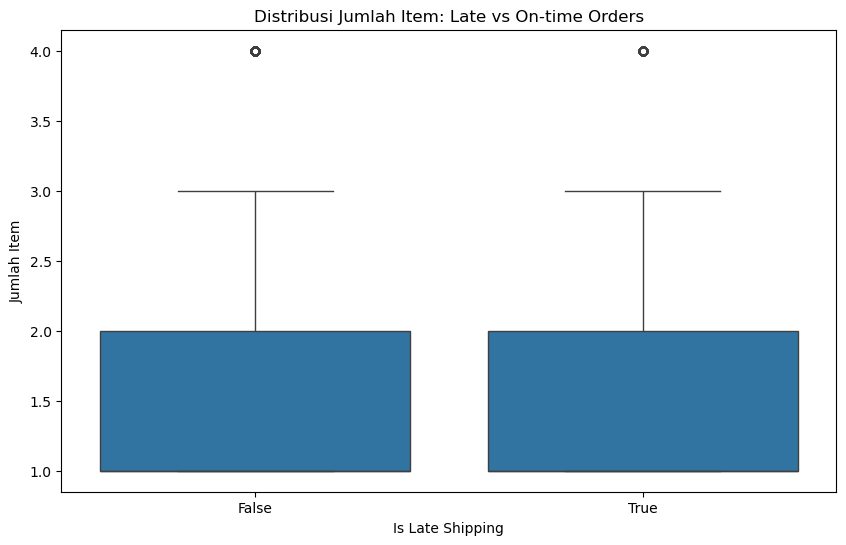

In [14]:
#Menambah kolom is_late untuk menandai
order['is_late'] = order['shipping_duration'] > 1

# Analisis statistik berdasarkan status keterlambatan pengiriman
print("Statistik jumlah item berdasarkan status pengiriman:")
stats_by_status = order.groupby('is_late')['num_of_item'].describe()
print(stats_by_status)

# Visualisasi box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_late', y='num_of_item', data=order)
plt.title('Distribusi Jumlah Item: Late vs On-time Orders')
plt.xlabel('Is Late Shipping')
plt.ylabel('Jumlah Item')
plt.show()



b. Analisis rate keterlambatan per jumlah item

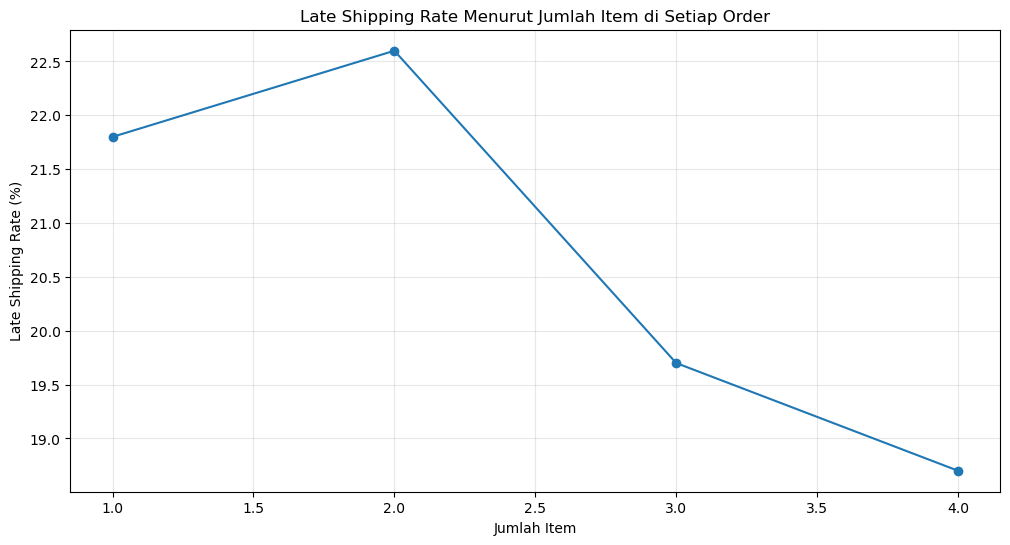


Analisis Late Shipping berdasarkan jumlah item:

Jumlah item dengan late rate tertinggi:
             total_orders  late_orders  late_rate
num_of_item                                      
2                    2225          502      0.226
1                    7911         1727      0.218
3                     557          110      0.197

Jumlah item dengan late rate terendah:
             total_orders  late_orders  late_rate
num_of_item                                      
4                     579          108      0.187
3                     557          110      0.197
1                    7911         1727      0.218


In [15]:
#Membuat dataframe untuk data yang pengiriman terlambat (>1 Hari) dikelompokkan berdasar jumlah item setiap order
item_analysis = order.groupby('num_of_item').agg({
    'is_late': ['count', 'sum', 'mean']
}).round(3)

item_analysis.columns = ['total_orders', 'late_orders', 'late_rate']

# Visualisasi late rate berdasarkan jumlah item
plt.figure(figsize=(12, 6))
plt.plot(item_analysis.index, item_analysis['late_rate'] * 100, marker='o')
plt.title('Late Shipping Rate Menurut Jumlah Item di Setiap Order')
plt.xlabel('Jumlah Item')
plt.ylabel('Late Shipping Rate (%)')
plt.grid(True, alpha=0.3)
plt.show()

# Print statistik
print("\nAnalisis Late Shipping berdasarkan jumlah item:")
print("\nJumlah item dengan late rate tertinggi:")
print(item_analysis.nlargest(3, 'late_rate'))
print("\nJumlah item dengan late rate terendah:")
print(item_analysis.nsmallest(3, 'late_rate'))

c. Perbandingan distribusi order berdasarkan banyak item

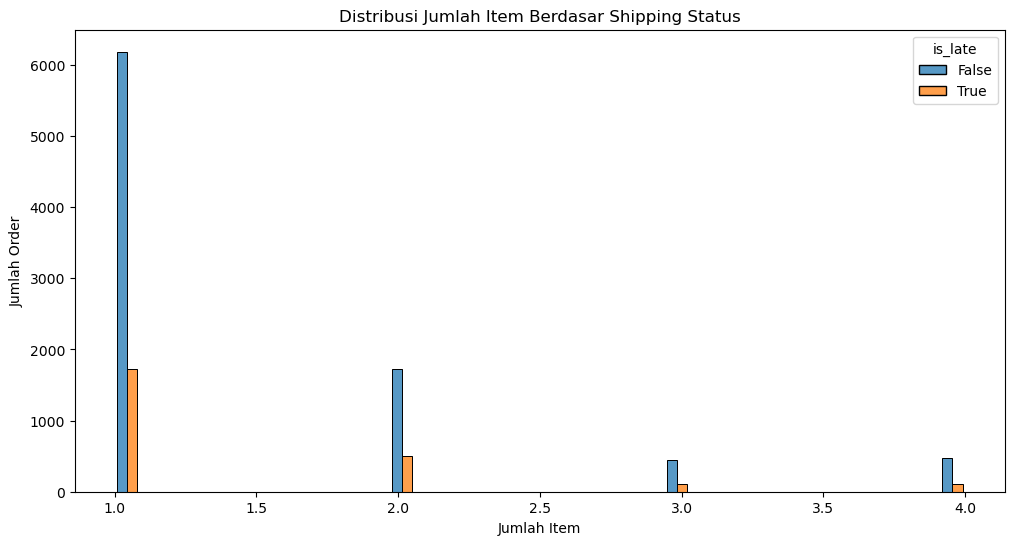

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(data=order, x='num_of_item', hue='is_late', multiple="dodge", shrink=.8)
plt.title('Distribusi Jumlah Item Berdasar Shipping Status')
plt.xlabel('Jumlah Item')
plt.ylabel('Jumlah Order')
plt.show()

Terdapat keidentikan distribusi jumlah item setiap order terhadap keterlambatan pengiriman dibandingkan pengiriman yang tepat waktu. Terdapat kemungkinan penyebab faktor keterlambatan bukan dari jumlah item dalam suatu order.<br><br>
Pada analisa rate keterlambatan pada setiap item, terlihat kecenderungan item dengan jumlah sedikit memiliki rate yang lebih besar. Dan jika dilihat dari jumlah order pada setiap item menunjukkan angka yang semakin besar juga ketika item semakin kecil. Terjadi perbedaan hasil dari analisa statistik dan rate. Perlu di dalami lagi analisa untuk diketahui faktor yang dapat mempengaruhi.<br><br>
Ketika dianalisa dengan membandingkan keseluruhan order yang dibuat pada setiap item terlihat jumlah order yang lebih banyak cenderung meningkatkan keterlambatan pengiriman.


<h3>2. Durasi Pengiriman Hingga Diterima Konsumen.</h3>

In [17]:
i=1
while True:
    late_delivery = order[order['delivery_duration'] > i].shape[0]
    late_delivery_rate = late_delivery / shipped_orders * 100
    print(f'Persentase durasi pengiriman sampai ke customer lebih dari {i} hari : {late_delivery} ({late_delivery_rate:.2f} %)')
    i+=1
    if late_delivery == 0:
        break

Persentase durasi pengiriman sampai ke customer lebih dari 1 hari : 2357 (31.84 %)
Persentase durasi pengiriman sampai ke customer lebih dari 2 hari : 1537 (20.76 %)
Persentase durasi pengiriman sampai ke customer lebih dari 3 hari : 747 (10.09 %)
Persentase durasi pengiriman sampai ke customer lebih dari 4 hari : 0 (0.00 %)


In [18]:
# Gabungkan order dengan order_items
merge_order_items = pd.merge(order, order_items, on='order_id')

# Gabungkan dengan inventory_items untuk data DC
merge_order_items = pd.merge(merge_order_items, inventory_item, left_on='product_id', right_on='product_id')

# Gabungkan dengan DC untuk mendapatkan koordinat DC
merge_order_items = pd.merge(merge_order_items, dc_loc, left_on='product_distribution_center_id', right_on='id')

# Gabungkan dengan users untuk mendapatkan lokasi pengguna
merge_order_items = pd.merge(merge_order_items, user, left_on='user_id_x', right_on='id', suffixes=('_order', '_user'))

# Gabungkan dengan products untuk mendapatkan kategori produk
merge_order_items = pd.merge(merge_order_items, product, left_on='product_id', right_on='id')

# Hitung jarak pengiriman
merge_order_items['distance_km'] = merge_order_items.apply(
    lambda row: geodesic((row['latitude_user'], row['longitude_user']), 
                         (row['latitude_order'], row['longitude_order'])).kilometers, axis=1)

# Analisis hubungan jarak dengan durasi pengiriman
distance_delivery_corr = merge_order_items[['distance_km', 'delivery_duration']].corr().iloc[0, 1]

# Rata-rata durasi pengiriman berdasarkan kategori produk
avg_duration_by_category = merge_order_items.groupby('product_category')['delivery_duration'].mean().reset_index()

# Rata-rata durasi pengiriman berdasarkan negara bagian pengguna
avg_duration_by_state = merge_order_items.groupby('state')['delivery_duration'].mean().reset_index()

# Output hasil analisis
print("Korelasi Jarak vs Durasi Pengiriman:", distance_delivery_corr)
print("\nDurasi Pengiriman Berdasarkan Kategori Produk:")
print(avg_duration_by_category.head())
print("\nDurasi Pengiriman Berdasarkan Negara Bagian:")
print(avg_duration_by_state.head())


Korelasi Jarak vs Durasi Pengiriman: 0.024003650035780717

Durasi Pengiriman Berdasarkan Kategori Produk:
    product_category  delivery_duration
0        Accessories           1.966102
1             Active           1.860553
2  Blazers & Jackets           2.044554
3      Clothing Sets           1.500000
4            Dresses           2.030233

Durasi Pengiriman Berdasarkan Negara Bagian:
     state  delivery_duration
0     Acre           3.933333
1    Aichi           4.000000
2  Alabama           1.647059
3  Alagoas           2.476190
4   Alaska                NaN


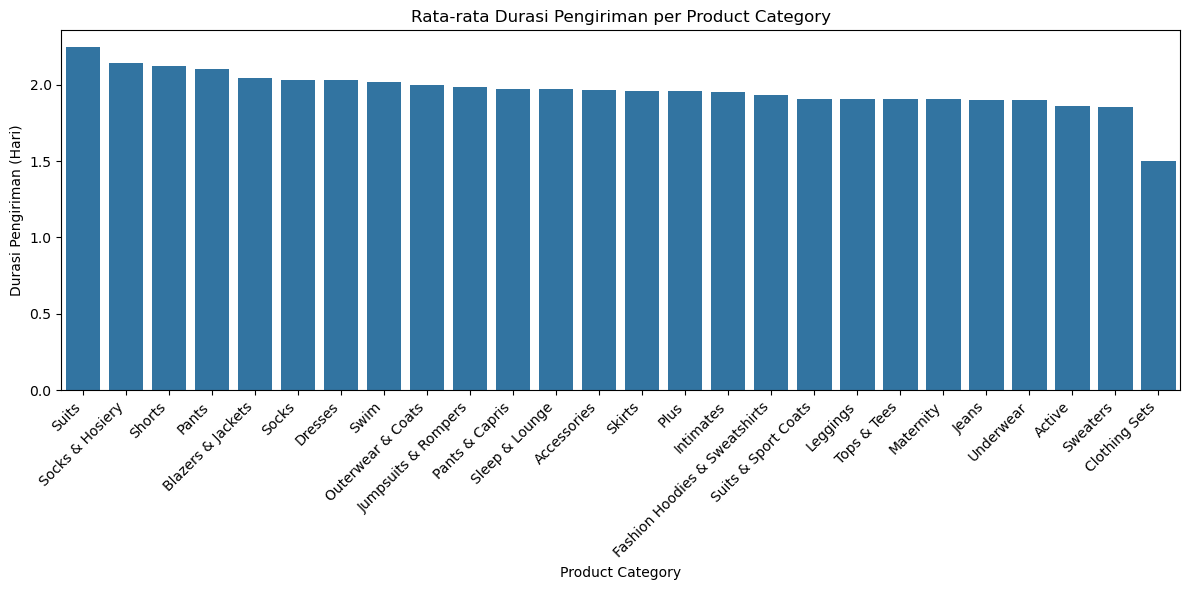

In [19]:
#Visualisasi durasi pengiriman per product category
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_duration_by_category.sort_values(by='delivery_duration', ascending=False), x='product_category', y='delivery_duration')

plt.title('Rata-rata Durasi Pengiriman per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Durasi Pengiriman (Hari)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

Terlihat durasi pengiriman dari setiap kategori product tidak terlalu signifikan berbeda.

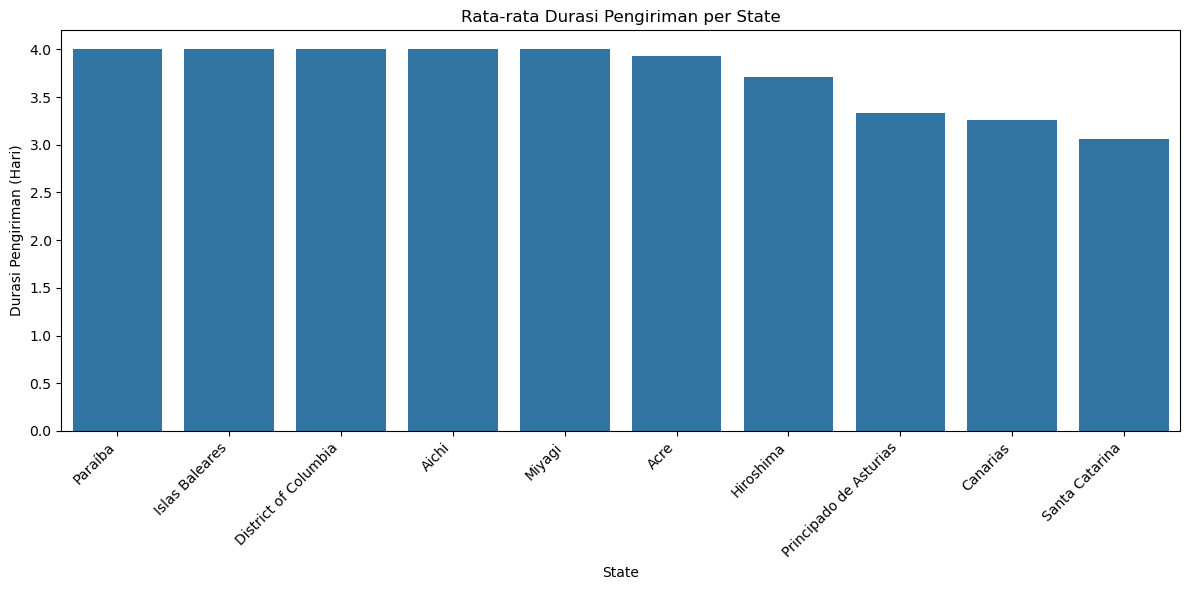

In [20]:
#Visualisasi durasi pengiriman per state
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_duration_by_state.sort_values(by='delivery_duration', ascending=False).head(10), x='state', y='delivery_duration')

plt.title('Rata-rata Durasi Pengiriman per State')
plt.xlabel('State')
plt.ylabel('Durasi Pengiriman (Hari)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

<h3>Analisis Durasi Pengiriman per State</h3>

Terdapat perbedaan rata rata kecepatan pengiriman barang hingga sampai ke customer disetiap state. Perbedaan tersebut dianalisa dan digolongkan sebagai berikut:
##### a. Pengiriman Cepat (0-1 hari)
- State dengan infrastruktur logistik yang baik
- Kemungkinan memiliki DC terdekat
- Volume pengiriman optimal
##### b. Pengiriman Normal (2-3 hari)
- Durasi standar untuk sebagian besar state
- Mencerminkan rata-rata nasional
- Kinerja logistik yang stabil
##### c. Pengiriman Lambat (>3 hari)
- Mungkin terkendala jarak dengan DC
- Potensi bottleneck dalam proses distribusi
- Perlu evaluasi rute pengiriman

<h4>Faktor-faktor yang Mempengaruhi</h4>

##### a. Geografis
- Jarak dari DC terdekat
- Kondisi infrastruktur transportasi
- Karakteristik wilayah (kepulauan, pegunungan, dll)
##### b. Operasional
- Volume pengiriman (count orders)
- Kapasitas handling di setiap state
- Ketersediaan partner logistik

<h4>Implikasi Bisnis</h4>

Durasi dari pengiriman akan berpengaruh terhadap Customer Experience seperti:
- State dengan durasi pengiriman cepat cenderung memiliki kepuasan pelanggan lebih tinggi
- Area dengan pengiriman lambat berisiko tinggi terhadap komplain
- Potensi dampak pada repeat order


<h2>B. Stock Performence</h2>

<h3>1. Pembatalan Pesanan</h3>

In [21]:
# Membuat dataframe untuk cancelled order
cancelled_orders = order.loc[order['status'] == 'Cancelled']

# Hitung selisih hari antara pemesanan dan pembatalan (asumsi pembatalan terjadi sebelum pengiriman)
cancelled_orders['days_to_cancel'] = (cancelled_orders['created_at'].max() - cancelled_orders['created_at']).dt.days

# Hitung rata-rata waktu sebelum pembatalan terjadi
average_days_to_cancel = cancelled_orders['days_to_cancel'].mean()

# Hitung persentase pesanan yang dibatalkan
cancelled_percentage = (len(cancelled_orders) / total_orders) * 100

print(f'Persentase pembatalan order : {cancelled_percentage:.2f}%')
print(f'Rata-rata durasi hari untuk order cancel: {average_days_to_cancel:.2f} hari')


Persentase pembatalan order : 14.57%
Rata-rata durasi hari untuk order cancel: 87.88 hari


C:\Users\Ideapad Pro 5i\AppData\Local\Temp\ipykernel_6476\2941643159.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  order['year_month'] = order['created_at'].dt.to_period('M')


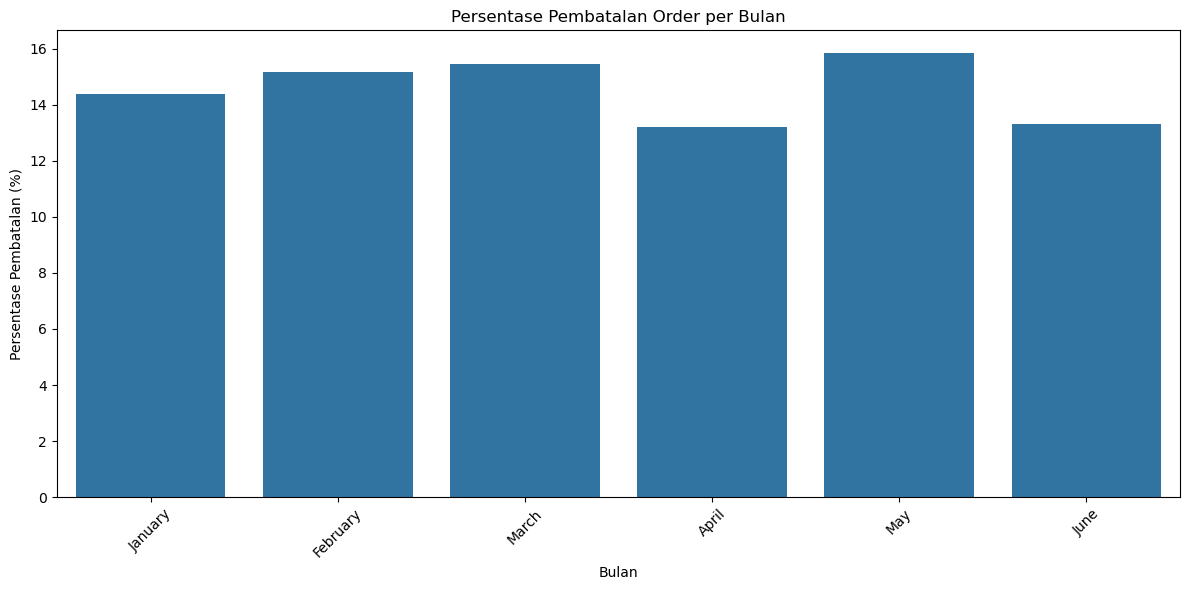

In [22]:
# Tambahkan kolom bulan dan tahun untuk analisis tren waktu
order['year_month'] = order['created_at'].dt.to_period('M')
order['month'] = order['created_at'].dt.month_name()

# Hitung total order dan order yang dibatalkan per bulan
monthly_orders = order.groupby(['year_month', 'month']).size()
monthly_cancelled = order[order['status'] == 'Cancelled'].groupby(['year_month', 'month']).size()

# Gabungkan dan hitung persentase pembatalan
monthly_summary = pd.DataFrame({
    'total_orders': monthly_orders,
    'cancelled_orders': monthly_cancelled
}).fillna(0)

monthly_summary['cancelled_ratio'] = (monthly_summary['cancelled_orders'] / monthly_summary['total_orders']) * 100

monthly_summary.reset_index(inplace=True)

#Visualisasi pembatalan setiap bulan
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_summary.sort_values(by='year_month'), x='month', y='cancelled_ratio')

plt.title('Persentase Pembatalan Order per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Persentase Pembatalan (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Rata-rata 14.57% order mengalami pembatalan setiap bulannya, yang cukup tinggi.<br>

Mei 2023 mencatat tingkat pembatalan tertinggi (15.9%), sementara April dan Juni sedikit lebih rendah.

In [23]:
# Gabungkan ulang order_items dengan inventory
merged_orders = order_items.merge(inventory_item, on='product_id', how='left')

# Hitung jumlah pembatalan per produk
cancelled_products = merged_orders[merged_orders['status'] == 'Cancelled']

# Kelompokkan berdasarkan product_id dan hitung jumlah pembatalan
cancelled_product_counts = cancelled_products['product_id'].value_counts().reset_index()
cancelled_product_counts.columns = ['product_id', 'cancel_count']

# Gabungkan dengan dataset produk untuk mendapatkan nama produk
cancelled_product_details = pd.merge(cancelled_product_counts, product, left_on='product_id', right_on='id')

# Urutkan berdasarkan jumlah pembatalan terbanyak
top_cancelled_products = cancelled_product_details[['product_id', 'name', 'cancel_count']].sort_values(by='cancel_count', ascending=False).head(10)


In [24]:
# Ambil daftar id produk tersebut
top_product_id = top_cancelled_products['product_id'].tolist()

# Filter inventory berdasarkan produk_id tersebut
stock_inventory = inventory_item[inventory_item['product_id'].isin(top_product_id)].copy()

# Tandai apakah produk sudah terjual
stock_inventory['is_sold'] = stock_inventory['sold_at'].notna()

# Hitung status stok per produk (terjual vs tidak)
stock_status_summary = stock_inventory.groupby(['product_id', 'is_sold']).size().unstack(fill_value=0)

stock_status_summary


is_sold,False,True
product_id,,
14306,3,3
16595,2,4
18016,3,3
18281,4,2
23803,4,3
26019,4,2
26714,4,3
27896,2,4
28318,4,3


Dari data top product yang dibatalkan ternyata masih memiliki stock yang tersedia. Permasalahan kemungkinan bukan dari permasalahan ketersediaan stock.

In [25]:
print(f'Rata-rata durasi orderan dibatalkan setelah dibuat : {cancelled_orders['days_to_cancel'].mean():.2f} hari')
print(f'Minimal durasi orderan dibatalkan setelah dibuat : {cancelled_orders['days_to_cancel'].min()} hari')
print(f'Maksimal durasi orderan dibatalkan setelah dibuat : {cancelled_orders['days_to_cancel'].max()} hari')
print(f'Median hari terjadi pembatalan order: {cancelled_orders['days_to_cancel'].median():.2f} hari')
print(f'Standard deviation: {cancelled_orders['days_to_cancel'].std():.2f} hari')

Rata-rata durasi orderan dibatalkan setelah dibuat : 87.88 hari
Minimal durasi orderan dibatalkan setelah dibuat : 0 hari
Maksimal durasi orderan dibatalkan setelah dibuat : 179 hari
Median hari terjadi pembatalan order: 88.00 hari
Standard deviation: 51.72 hari


Rata-rata durasi terjadi pembatalan setelah orderan dibuat sangatlah tinggi. Pembatalan kemungkinan terjadi karena tidak adanya progres di order yang mereka buat. 

<h3>2. Pengembalian Order</h3>

In [26]:
# Filter order yang berstatus 'Returned'
returned_orders = order[order['status'] == 'Returned']

# Gabungkan order_items dengan order yang diretur
returned_items = order_items.merge(returned_orders[['order_id']], on='order_id', how='inner')

# Gabungkan returned_items dengan product untuk mendapatkan informasi brand
returned_items = returned_items.merge(
    product[['id', 'brand']], 
    left_on='product_id', 
    right_on='id'
)

# Hapus kolom id yang duplikat
returned_items = returned_items.drop(['id_x','id_y'], axis=1)

# Hitung jumlah retur per produk
returned_product_counts = returned_items['product_id'].value_counts().reset_index()
returned_product_counts.columns = ['product_id', 'return_count']

# Gabungkan dengan produk untuk mendapatkan nama produk
returned_product_details = returned_product_counts.merge(product, left_on='product_id', right_on='id', how='left')

# Ambil 10 produk dengan retur terbanyak
top_returned_products = returned_product_details[['id', 'name', 'return_count']].sort_values(by='return_count', ascending=False).head(10)


top_returned_products


,id,name,return_count
0,17128,Authentic Pigment 11 oz. Pigment-Dyed Fleece C...,2
33,25260,Harbor Bay Big & Tall 2-Pack Argyle Socks,2
24,20573,Carhartt Men's Washed Denim Work Jeans,2
25,2291,Anna-Kaci S/M Fit Multicoloured Graffit Inspir...,2
26,16250,Nautica Men's Sun Drenched Colorblock Polo,2
27,24000,Men's Kuhl Spy Wool Sweater Jacket,2
28,8268,HALSTON HERITAGE Women's Oversized Double Face...,2
29,19114,Pendleton Men's Argyle Cardigan Vest,2
30,24185,Polo Ralph Lauren Men Pony Logo Classic Jacket,2
32,25243,Polo Ralph Lauren Big & Tall Men's 3-Pack Clas...,2


Jumlah pengembalian berdasarkan product relatif sama, sehingga tidak ada issue berkaitan kualitas suatu product.

In [27]:
# Analisis pengembalian per brand
brand_returns = returned_items.groupby('brand').agg({
    'product_id': 'count',
    'sale_price': 'mean'
}).reset_index()
brand_returns.columns = ['brand', 'return_count', 'avg_price']

# Hitung total order per brand
brand_total_orders = order_items.merge(
    product[['id', 'brand']], 
    left_on='product_id', 
    right_on='id'
).groupby('brand').size().reset_index()
brand_total_orders.columns = ['brand', 'total_orders']

# Gabungkan data
brand_analysis = brand_returns.merge(brand_total_orders, on='brand')
brand_analysis['return_rate'] = (brand_analysis['return_count'] / brand_analysis['total_orders']) * 100

# Urutkan berdasarkan return rate
brand_analysis = brand_analysis.sort_values('return_count', ascending=False).reset_index()
brand_analysis.head(10)

,index,brand,return_count,avg_price,total_orders,return_rate
0,32,Allegra K,49,13.457959,536,9.141791
1,111,Calvin Klein,24,54.612917,280,8.571429
2,118,Carhartt,21,84.461905,232,9.051724
3,375,Levi's,20,62.616000,157,12.738854
4,437,Nautica,20,48.438000,171,11.695906
5,653,Volcom,19,43.872632,196,9.693878
6,276,Hanes,18,19.497778,189,9.523810
7,560,Speedo,14,51.722143,115,12.173913
8,274,Haggar,13,56.930000,88,14.772727
9,614,Tommy Hilfiger,13,45.146923,156,8.333333


Terdapat brand dengan jumlah pengembalian cukup besar namun tergolong masih wajar jika dilihat dari return ratenya.

In [28]:
category_analysis = returned_product_details['category'].value_counts().reset_index()
category_analysis.head(10)

,category,count
0,Tops & Tees,110
1,Jeans,105
2,Shorts,104
3,Intimates,103
4,Sleep & Lounge,97
5,Swim,96
6,Accessories,95
7,Fashion Hoodies & Sweatshirts,87
8,Sweaters,86
9,Active,77


Terdapat category atau tipe product yang cenderung lebih tinggi jumlah pengembaliannya.

In [29]:
# Analisis distribusi sale_price
sale_price_stats = order_items['sale_price'].describe()
print("Statistik sale_price:")
print(sale_price_stats)

# Tentukan threshold berdasarkan quartile
q1 = sale_price_stats['25%']
q3 = sale_price_stats['75%']

# Tambahkan kolom status harga
returned_items['price_status'] = pd.cut(
    returned_items['sale_price'],
    bins=[0, q1, q3, float('inf')],
    labels=['Murah', 'Sedang', 'Mahal']
)

Statistik sale_price:
count    16312.000000
mean        60.549077
std         68.749456
min          1.500000
25%         24.950001
50%         39.995001
75%         69.989998
max        999.000000
Name: sale_price, dtype: float64


In [30]:
price_analysis = returned_items['price_status'].value_counts().reset_index()
price_analysis

,price_status,count
0,Sedang,753
1,Mahal,412
2,Murah,390


#### Analisa Pengembalian Product
- Masalah pengembalian tidak berkorelasi pada brand.
- Ada korelasi antara tipe produk (seperti pakaian atas dan jeans) dengan tingkat pengembalian, terdapat kemungkinan terkait dengan masalah ukuran dan fit.
- Harga produk bukan faktor utama dalam pengembalian, karena produk dengan harga menengah justru memiliki jumlah pengembalian tertinggi

<h3>3. Stock Turnover</h3>

In [31]:
max_date = inventory_item['created_at'].max() + pd.Timedelta(days=1)

# Hitung umur stok (dalam hari)
inventory_item['stock_age'] = (max_date - inventory_item['created_at']).dt.days

In [32]:
# Uji ANOVA untuk perbedaan kategori
categories = inventory_item['product_category'].unique()
category_groups = [inventory_item[inventory_item['product_category'] == cat]['stock_age'] for cat in categories]
f_stat, p_value = f_oneway(*category_groups)
print("\nUji ANOVA untuk Perbedaan Kategori:")
print(f"F-statistic: {f_stat}, p-value: {p_value}")


Uji ANOVA untuk Perbedaan Kategori:
F-statistic: 0.49830713067383503, p-value: 0.9824669965405562


Hasil ANOVA yaitu p-value >= 0.05, H0 ditolak. Sehingga tidak ada perbedaan signifikan umur antar category product

Untuk mengetahui kecepatan perputaran persediaan product perlu dilakukan perhitungan stock turnover agar supply chain lebih efisien

In [33]:
# 1. Gabungkan inventory_item dengan product
stock_data = inventory_item.merge(
    product[['id', 'category']],
    left_on='product_id',
    right_on='id'
)
# Hapus kolom id yang duplikat
stock_data = stock_data.drop(['id_x','id_y'], axis=1)

# 2. Hitung Total Quantity Sold per Product
# Gabungkan order_item dengan product untuk mendapatkan quantity sold
sales_data = order_items.merge(
    product[['id', 'category']],
    left_on='product_id',
    right_on='id'
)
# Hapus kolom id yang duplikat
sales_data = sales_data.drop(['id_x','id_y'], axis=1)

# Hitung total quantity sold per product
total_sold = sales_data['product_id'].value_counts().reset_index(name='sold')

In [34]:
# 3. Hitung Available Quantity per Product
available_stock = stock_data[stock_data['sold_at'].isnull()]
available_quantity = available_stock['product_id'].value_counts().reset_index(name='available_quantity')

# 4. Gabungkan Total Sold dan Available Quantity
turnover_data = total_sold.merge(
    available_quantity,
    on='product_id',
    how='left'
)

# 5. Hitung Stock Turnover Ratio
turnover_data['stock_turnover_ratio'] = turnover_data['sold'] / turnover_data['available_quantity']
turnover_data = turnover_data.merge(
    inventory_item[['product_id', 'product_category', 'product_brand']],
    left_on='product_id',
    right_on='product_id',
    how='inner'
).drop_duplicates(subset=['product_id'])
turnover_data

,product_id,sold,available_quantity,stock_turnover_ratio,product_category,product_brand
0,27998,5,4.0,1.25,Swim,Body Glove
9,24334,5,NaN,NaN,Outerwear & Coats,Dickies
14,19728,5,2.0,2.50,Sweaters,Crazy Granny
20,16926,5,1.0,5.00,Tops & Tees,Pacific Legend
27,20956,5,NaN,NaN,Jeans,Joe's Jeans
...,...,...,...,...,...,...
29118,25907,1,NaN,NaN,Underwear,Hanes
29119,18643,1,1.0,1.00,Active,Charles River Apparel
29121,2284,1,NaN,NaN,Fashion Hoodies & Sweatshirts,Anna-Kaci
29122,8687,1,1.0,1.00,Outerwear & Coats,Allegra K


<h4>3.1 Stock Turnover per Category Terlaris</h4>

In [35]:
# Gabungkan order_items dengan products
order_product = order_items.merge(
    product[['id', 'category']],
    left_on='product_id',
    right_on='id'
)
# Hapus kolom id yang duplikat
order_product = order_product.drop(['id_x','id_y'], axis=1)

rank_top10_category = order_product['category'].value_counts().head(10).reset_index()
rank_top10_category

,category,count
0,Intimates,1151
1,Jeans,1144
2,Tops & Tees,1104
3,Fashion Hoodies & Sweatshirts,1060
4,Swim,1048
5,Sleep & Lounge,1042
6,Shorts,1032
7,Sweaters,1000
8,Accessories,891
9,Active,845


In [36]:
list_category = rank_top10_category['category'].tolist()

#Mengambil data inventory sesuai dengan top 10 category
selected_category_st = turnover_data[turnover_data['product_category'].isin(list_category)]
top10_category_st = selected_category_st.groupby('product_category').agg({
    'available_quantity':'sum',
    'sold':'sum',
    'stock_turnover_ratio':'mean'
})
top10_category_st.sort_values('stock_turnover_ratio', ascending=False)

,available_quantity,sold,stock_turnover_ratio
product_category,,,
Tops & Tees,979.0,1075,0.983781
Sleep & Lounge,883.0,1018,0.971150
Fashion Hoodies & Sweatshirts,914.0,1024,0.967272
Accessories,746.0,857,0.967041
Shorts,884.0,999,0.965353
Intimates,863.0,1107,0.961059
Active,756.0,823,0.948270
Sweaters,889.0,980,0.947149
Swim,897.0,1027,0.946371


Kategori Sleep & Lounge dan Top&Teens memiliki perputaran stok terbaik, sementara kategori Swim dan Jeans menjadi terendah dalam perputaran stock. Walaupun silisihnya tidak begitu signifikan.

<h4>3.2 Stock Turnover per Brand Terlaris</h4>

In [37]:
#menggabungkan order item, product, dan inventory item
order_product_inventory = order_product.merge(
    inventory_item[['product_id', 'product_brand']],
    on='product_id'
)
top10_brand = order_product_inventory['product_brand'].value_counts().head(10).reset_index()
top10_brand

,product_brand,count
0,Allegra K,1389
1,Calvin Klein,709
2,Carhartt,627
3,Volcom,607
4,Nautica,520
5,Hanes,456
6,Levi's,442
7,Dockers,419
8,Tommy Hilfiger,412
9,Quiksilver,406


In [38]:
list_top10_brand = top10_brand['product_brand'].tolist()

#Mengambil data inventory sesuai dengan top 10 brand
selected_inventory_brand = turnover_data[turnover_data['product_brand'].isin(list_top10_brand)]

# Hitung stock turnover ratio per brand
top10_brand_st = selected_inventory_brand.groupby('product_brand').agg({
    'available_quantity':'sum',
    'sold':'sum',
    'stock_turnover_ratio':'mean'
})
top10_brand_st.sort_values('stock_turnover_ratio', ascending=False)

,available_quantity,sold,stock_turnover_ratio
product_brand,,,
Nautica,168.0,170,1.037993
Levi's,134.0,150,1.035088
Carhartt,199.0,226,1.019306
Volcom,176.0,194,1.016495
Quiksilver,117.0,160,1.008784
Calvin Klein,222.0,279,0.985012
Tommy Hilfiger,139.0,151,0.960823
Allegra K,466.0,520,0.927939
Hanes,140.0,183,0.922016


Brand Noutica dan levis menunjukkan kinerja perputaran stok yang sangat baik, sementara Dockers dan Hanes perlu evaluasi strategi inventory management.

<h3>4. Stock Aging</h3>

<h4>4.1 Stock Aging Top Category</h4>

In [39]:

# Analisis stock aging per kategori
stock_aging_category = inventory_item.merge(
    product[['id', 'category']],
    left_on='product_id',
    right_on='id'
).groupby('category').agg({
    'stock_age': ['mean', 'median', 'max']
}).reset_index()

stock_aging_category.columns = ['category', 'avg_age', 'median_age', 'max_age']
stock_aging_category = stock_aging_category.sort_values('avg_age', ascending=False)
print("\nStock Aging per Kategori:")
print(stock_aging_category.head(10))


Stock Aging per Kategori:
           category    avg_age  median_age  max_age
20            Suits  94.890688        98.0      180
13   Pants & Capris  91.253239        89.0      180
14             Plus  90.872745        92.0      180
24      Tops & Tees  90.665066        91.0      180
6         Intimates  90.306988        90.0      180
17   Sleep & Lounge  90.291798        91.0      180
22         Sweaters  90.253974        90.0      180
19  Socks & Hosiery  90.243547        88.0      180
1            Active  89.995759        88.0      180
18            Socks  89.810761        91.0      180


<h4>4.2 Older Stock</h4>

In [40]:
# Identifikasi produk dengan umur stok tertua
oldest_stock = inventory_item.merge(
    product[['id', 'name', 'category', 'brand']],
    left_on='product_id',
    right_on='id'
).sort_values('stock_age', ascending=False)

print("\nTop 10 Produk dengan Umur Stok Tertua:")
print(oldest_stock[['name', 'category', 'brand', 'stock_age']].head(10))



Top 10 Produk dengan Umur Stok Tertua:
                                                    name             category  \
5257                    Joe's Jeans Women's Opale Jacket    Blazers & Jackets   
34659  Men's Superior 150s Single Breasted Two Button...  Suits & Sport Coats   
681    Dickies Men's Web Belt with Antique Nickel Finish          Accessories   
38101  Beach Depot UPF 50+ Men's Short Sleeve Rash Gu...                 Swim   
27678  Allegra K Woman Elastic Waist Irregular Chiffo...               Skirts   
30963  Women's Cotton Rich Knit Lounge Pants - Many C...       Sleep & Lounge   
4497   Underworks Mens Extreme Gynecomastia Chest Bin...               Active   
24851              neff Women's Daily Sparkle Beanie Hat                 Plus   
10250            Amazing Shape Mid-Thigh Bodysuit Shaper            Intimates   
16749  Allegra K Ladies Elastic Waist Cartoon Cats Pa...             Leggings   

                 brand  stock_age  
5257       Joe's Jeans        18

Dari hasil menunjukan rata-rata stock aging dari top 10 category tidak terlalu berbeda. Terlihat juga terdapat product yang sudah lama tersimpan warehouse belum juga terjual.

<h3>5. Stock Level Optimization</h3>

In [41]:

# Hitung safety stock level
# Safety Stock = (Max Daily Sales × Max Lead Time) - (Average Daily Sales × Average Lead Time)
daily_sales = order_items.groupby(['product_id', 'created_at']).size().reset_index()
daily_sales.columns = ['product_id', 'date', 'sales_count']

safety_stock = daily_sales.groupby('product_id').agg({
    'sales_count': ['max', 'mean']
}).reset_index()
safety_stock.columns = ['product_id', 'max_daily_sales', 'avg_daily_sales']

# Asumsi lead time rata-rata 7 hari dan maksimal 14 hari
safety_stock['safety_stock_level'] = (safety_stock['max_daily_sales'] * 14) - (safety_stock['avg_daily_sales'] * 7)

# Gabungkan dengan data produk
safety_stock = safety_stock.merge(
    product[['id', 'name', 'category', 'brand']],
    left_on='product_id',
    right_on='id'
)

print("\nProduk yang Perlu Safety Stock Tinggi:")
print(safety_stock.sort_values('safety_stock_level', ascending=False)[['name', 'category', 'brand', 'safety_stock_level']].head(10))




Produk yang Perlu Safety Stock Tinggi:
                                                   name             category  \
0                        Bailey 44 Women's Undertow Top          Tops & Tees   
8294  Elie Tahari Mens 2 Button Flat Front Black Pin...  Suits & Sport Coats   
8272                      Afazzy Chestnut Travel Blazer  Suits & Sport Coats   
8273       Marc Ecko Cut & Sew Men's Herringbone Blazer  Suits & Sport Coats   
8274              7 Diamonds Men's Lovers In Japan Coat  Suits & Sport Coats   
8275  Savile Row Mens Grey Birdseye Italian Wool 2 B...  Suits & Sport Coats   
8276  Tuxedo Vest - Solid Satin with Matching Pin As...  Suits & Sport Coats   
8277  New Fashion Men's Slim Fit Two Button Window P...  Suits & Sport Coats   
8278            Synrgy Big & Tall Flat-Front Suit Pants  Suits & Sport Coats   
8279  Ralph Lauren Mens Tan Houndstooth Silk Wool Sp...  Suits & Sport Coats   

                       brand  safety_stock_level  
0                  Bailey 44

Semua produk memiliki nilai safety stock yang sama (7.0). Ini menunjukkan pola penjualan yang relatif stabil dan konsisten. Tidak ada variasi ekstrim dalam permintaan harian.

<h1>IV. Conclusion</h1>

**Variasi Durasi Pengiriman**: Durasi pengiriman dipengaruhi oleh state. Hal ini terjadi karena beberapa faktor yang belum ada dalam data, termasuk lokasi geografis (semakin jauh dari Distribution Center/DC, semakin lama). Selain itu kategori produk yang memiliki volume pengiriman yang besar menjadi faktor keterlambatan dalam pengiriman. Perlu dilakukan efisiensi partner logistik.<br><br>
**Pola Pembatalan dan Pengembalian Produk**: Tingkat pembatalan tercatat sebesar 14.57% dengan durasi rata-rata 87.88 hari. Menariknya, pembatalan tidak menunjukkan korelasi dengan kualitas produk. Sementara itu, tidak ditemukan pola pengembalian yang spesifik berdasarkan brand. Namun, kategori pakaian atas dan jeans menunjukkan tingkat pengembalian yang lebih tinggi, kemungkinan besar disebabkan oleh masalah ukuran atau ketidak sesuaian dengan deskripsi product.<br><br>
**Optimasi Rute Pengiriman**: Analisis membuka peluang untuk optimasi rute pengiriman melalui penambahan hub di area dengan durasi pengiriman yang lambat, pengembangan jaringan partner logistik yang lebih luas, implementasi sistem prediksi durasi pengiriman, dan optimasi berdasarkan analisis geografis.<br><br>
**Pola Distribusi Umur Stok**: Analisis menunjukkan adanya keseragaman yang mencolok dalam pola distribusi umur stok di seluruh kategori produk. Rata-rata umur stok berkisar antara 89 hingga 91 hari, dengan kategori Tops & Tees memiliki umur stok tertinggi (90.67 hari) dan Accessories terendah (89.02 hari). Keseragaman ini mengindikasikan kemungkinan adanya kebijakan manajemen stok yang terlalu general dan kurang mempertimbangkan karakteristik unik dari masing-masing kategori produk.<br><br>
**Faktor-faktor yang Mempengaruhi Tingkat Turnover Stok**: Beberapa faktor kunci teridentifikasi mempengaruhi tingkat turnover stok. Kategori produk menjadi salah satu faktor signifikan, terutama terlihat pada pola yang berbeda pada kategori Suits & Sport Coats. Selain itu, brand juga memainkan peran penting, di mana brand premium menunjukkan kebutuhan safety stock yang spesifik. Stabilitas pola penjualan harian dan konsistensi lead time (antara 7 hingga 14 hari) juga berkontribusi pada dinamika turnover stok. Analisis safety stock merekomendasikan level optimal sebesar 7.0 unit untuk produk-produk prioritas. Namun, rekomendasi yang lebih spesifik per kategori adalah mempertahankan level 7.0 untuk kategori formal (Suits & Sport Coats), mengevaluasi penurunan level untuk kategori casual, mempertahankan level tinggi untuk brand premium, dan menyesuaikan level berdasarkan pola historis untuk produk dengan turnover tinggi.

<h3>Rekomendasi</h3>

**Manajemen Stok**
Diperlukan diferensiasi kebijakan stok antar kategori, implementasi sistem rotasi stok yang lebih ketat (first-in, first-out), dan penyesuaian level safety stock yang lebih adaptif terhadap karakteristik masing-masing produk. Pengembangan model prediktif untuk manajemen stok yang lebih akurat<br><br>
**Operasional Pengiriman**
Fokus pada peningkatan shipping rate yang saat ini berada di angka 65.68%, optimasi jaringan logistik, dan peningkatan sistem tracking untuk memberikan visibilitas yang lebih baik kepada pelanggan. Untuk jangka panjang investasi pada infrastruktur logistik, termasuk kemungkinan pengembangan Distribution Center (DC) baru<br><br>
**Strategi Pembelian**
Kebijakan pembelian perlu disesuaikan berdasarkan analisis turnover, mempertimbangkan lead time dalam perencanaan stok, dan melakukan evaluasi berkala terhadap hubungan dengan supplier.